# Code of "Things you need to know to raise your Airbnb review score in Seattle" project
Three business questions investigated by this code:  
Question 1: are the review scores affected by how the hosts described their Airbnbs?  
Question 2: are the review scores affected by how the hosts described the neighborhood of their Airbnbs?  
Question 3: are the review scores affected by objective factors of the listings like price, room type, bed type, etc.?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from collections import defaultdict
%matplotlib inline

# import dataset
df_listings = pd.read_csv('./listings.csv')

In [ ]:
# run this cell to take a look at the first 5 rows of the data
df_listings.head()

The whole project cares about what affects the **rating scores** of a Airbnb listing, so the first step is deleting the listings with missing values in **'review_scores_rating'**.

In [2]:
df_new = df_listings.dropna(subset = ['review_scores_rating'], axis = 0)

Text(0.5, 0, 'Scores')

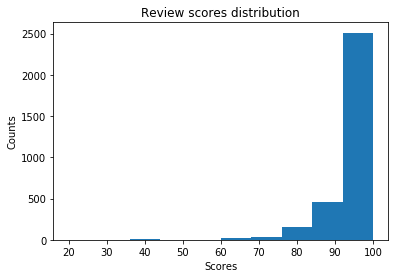

In [3]:
# run this cell to take a look at the ditribution of the rating scores of all the Airbnb listings in Seattle.
df_new.review_scores_rating.plot(kind = 'hist');
plt.title('Review scores distribution');
plt.ylabel('Counts');
plt.xlabel('Scores')
# uncomment the following line if you want to save the figure
# plt.savefig('Rating_distribution.png', dpi = 100)

### Comparing high rating score listings vs low rating score listings
I will first compare whether the Airbnb listings have higher rating scores are different from those with lower scores in some subjective factors -- such as how they describe the listing and the neighborhood (Question 1 & 2).   

To have two groups to compare, I extract those listings with higher scores (> 75% percentile) and lower scores(< 25% percentile).

## Solving Question 1
To simplify the question, I will only focus on the **adjectives** used in the descriptions.  

By looking through the descriptions in column **'description'** (a desciption of the Airbnb listing), I got some possible adjectives listing in the following variable **possible_adj**.

In [4]:
# We don't have NaN value in the 'description' variable
df_new.description.isnull().sum()

0

In [5]:
# separate data directly
y = df_new.review_scores_rating
df1_high = df_new[y > np.percentile(y,75)]
df1_low  = df_new[y < np.percentile(y,25)]

In [6]:
possible_adj = ['charming', 'private', 'elegant', 'cozy', 'comfortable', 
                'clean', 'wonderful', 'beautiful', 'modern', 'great',
                'functional', 'fresh', 'close', 'historic', 'quiet',
                'gorgeous', 'safe', 'convenient', 'lovely', 'vintage',
                'amazing', 'walkable', 'adorable', 'bright', 'light',
                'new', 'spacious', 'large', 'desirable', 'popular', 
                'special', 'fantastic', 'fabulous']

Here I use (modify) a code from Udacity class to count the number of above words showing in a column of a dataframe.

In [7]:
def count_word(df, col1, col2, look_for):
    '''
    Modified based on code from Udacity Data Scientist Nanodegree Lession 1. 
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col1]
    
    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx].lower():
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

The following function preprocess the dataframe you want to use and count the words (e.g. adjectives) of interest by calling the **count_word** function.

In [8]:
def get_count(df, col = 'description', search_for = possible_adj):
    '''
    Modified based on code from Udacity Data Scientist Nanodegree Lession 1.
    '''
    df_group = df[col].value_counts().reset_index()
    df_group.rename(columns={'index': 'key_words', col: 'count'}, inplace=True)
    df_key_word = count_word(df_group, 'key_words', 'count', search_for)
    
    df_key_word.set_index('key_words', inplace = True)
    return df_key_word

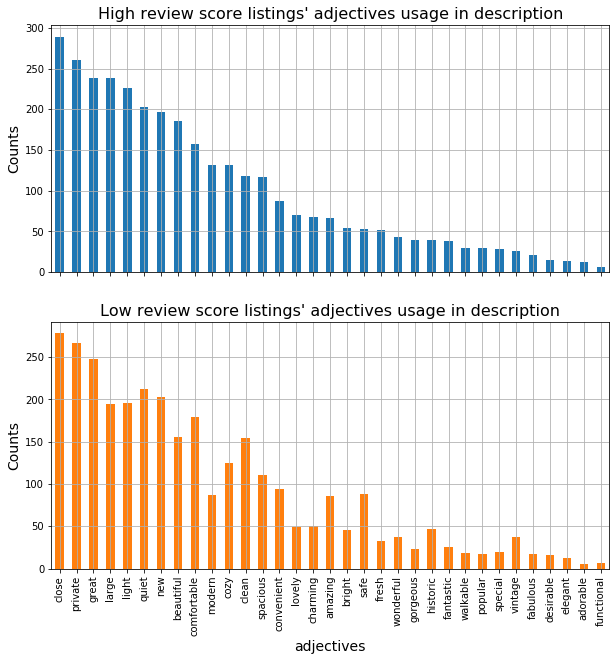

In [9]:
# plot out the adjective usage in high score listings and low score listings
adj_high      = get_count(df1_high)
adj_low       = get_count(df1_low)

count_adj = pd.concat([adj_high, adj_low], axis=1, join='inner')

ax1 = count_adj.plot.bar(legend = None, subplots=True, figsize = (10,10), grid = True)
ax1[0].set_xlabel('adjectives', fontsize = 14)
ax1[0].set_ylabel('Counts', fontsize = 14)
ax1[0].set_title("High review score listings' adjectives usage in description", fontsize = 16);
ax1[1].set_xlabel('adjectives', fontsize = 14)
ax1[1].set_ylabel('Counts', fontsize = 14)
ax1[1].set_title("Low review score listings' adjectives usage in description", fontsize = 16);

# uncomment the following two lines to save figure
#fig = ax1[0].get_figure()
#fig.savefig('Description_difference.png', dpi = 100)

### Answer of Question 1
It seems there is no significant difference in the adjective usage in the listing description between high rating score listings and low rating score listings -- at least the top three adjectives are the same between two groups.   

Only the word "modern" seems to be used more in high rating listings. 

## Solving Question 2
Next, I will explore whether the **description of the neighborhood** (column **'neighborhood_overview'**) affects the rating score.  

Similar to question 1, I will compare the adjectives usage between high rating listings and low rating listings.

In [10]:
# There are NaN values in 'neighborhood_overview'
df_new.neighborhood_overview.isnull().sum()

738

In [11]:
# Delete rows with NaN in 'neighborhood_overview'
df_q2 = df_new.dropna(subset = ['neighborhood_overview'], axis = 0)

In [12]:
# separate data into high rating group and low rating group
y_q2 = df_q2.review_scores_rating
df2_high = df_q2[y_q2 > np.percentile(y_q2,75)]
df2_low  = df_q2[y_q2 < np.percentile(y_q2,25)]

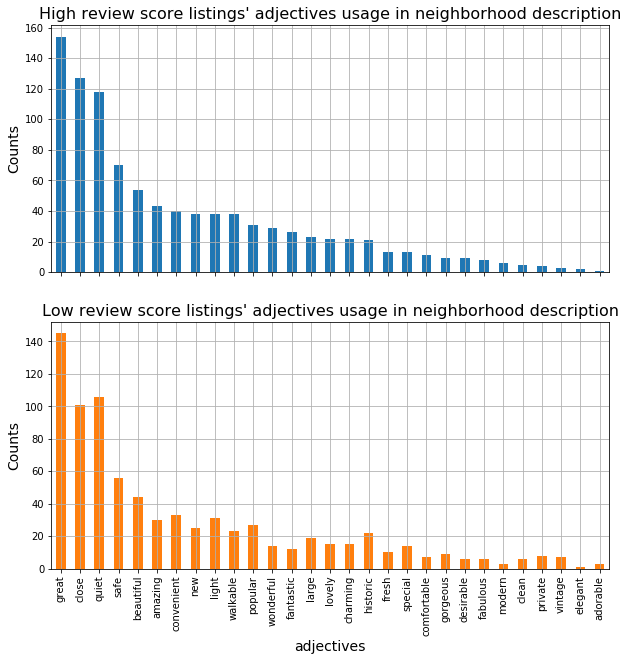

In [13]:
# use get_count funtion to sort out the adjective usage
adj_high_neighbor  = get_count(df2_high, col = 'neighborhood_overview')
adj_low_neighbor   = get_count(df2_low, col = 'neighborhood_overview')

count_adj_neighbor = pd.concat([adj_high_neighbor, adj_low_neighbor], axis=1, join='inner')

ax2 = count_adj_neighbor.plot.bar(legend = None, subplots=True, figsize = (10,10), grid = True)
ax2[0].set_xlabel('adjectives', fontsize = 14)
ax2[0].set_ylabel('Counts', fontsize = 14)
ax2[0].set_title("High review score listings' adjectives usage in neighborhood description", fontsize = 16);
ax2[1].set_xlabel('adjectives', fontsize = 14)
ax2[1].set_ylabel('Counts', fontsize = 14)
ax2[1].set_title("Low review score listings' adjectives usage in neighborhood description", fontsize = 16);

# uncomment the following two lines to save figure
#fig = ax2[0].get_figure()
#fig.savefig('Neighborhood_description_difference.png', dpi = 100)

Again, it seems the adjectives used in neighborhood overview between these two groups are not quite different from each other. And the top three adjectives are the same in the description of listings.  

Another factor of the description of neighborhood is nouns related to the entertainment and daily life, such as "shopping" and "coffee". By looking through the column **'neighborhood_overview'** I extract some daily life related nouns in the variable **possible_noun**.  

I will plot out the noun usage between high rating score listings and low rating score listings.

In [14]:
possible_noun = ['restaurants', 'food', 'bars', 'coffee', 'cafes', 
                 'shopping', 'grocery', 'mall', 'park', 'movie', 'music']

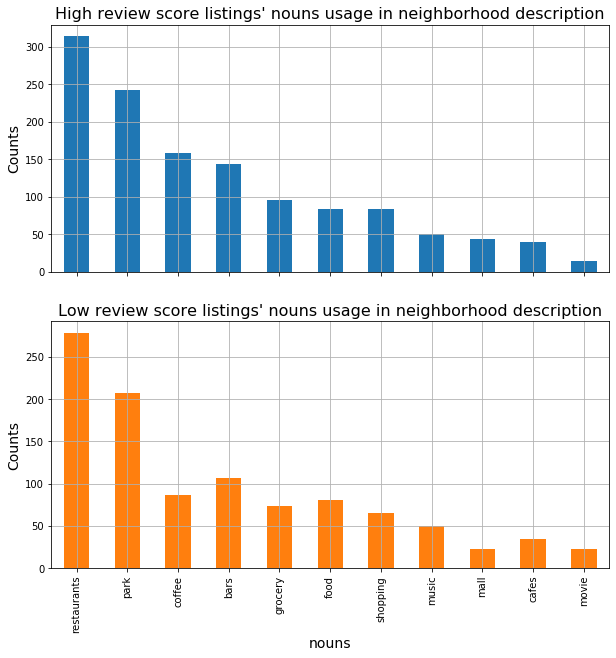

In [15]:
# use get_count funtion to sort out the noun usage
n_high_neighbor = get_count(df2_high, col = 'neighborhood_overview', search_for = possible_noun)
n_low_neighbor  = get_count(df2_low, col = 'neighborhood_overview', search_for = possible_noun)

count_n_neighbor = pd.concat([n_high_neighbor, n_low_neighbor], axis=1, join='inner')

ax3 = count_n_neighbor.plot.bar(legend = None, subplots=True, figsize = (10,10), grid = True)
ax3[0].set_xlabel('nouns', fontsize = 14)
ax3[0].set_ylabel('Counts', fontsize = 14)
ax3[0].set_title("High review score listings' nouns usage in neighborhood description", fontsize = 16);
ax3[1].set_xlabel('nouns', fontsize = 14)
ax3[1].set_ylabel('Counts', fontsize = 14)
ax3[1].set_title("Low review score listings' nouns usage in neighborhood description", fontsize = 16);

# uncomment the following two lines to save fig
#fig = ax3[0].get_figure()
#fig.savefig('Neighborhood_noun_difference.png', dpi = 100)

It seems subjective factors did not affect the review score rating. The next step is to explore the objective factors.

## Solving Question 3

All the objective factors of interests include: 

**Quantitive variables:**  
1) **'price_per_person'**: a new column I will create by dividing 'price' by 'accommodates' for each row  
2) 'security_deposit'  
3) 'cleaning_fee'  

**Categorical variables:**  
1) 'host_response_time': within an hour, within a few hours, within a day, a few days or more  
2) 'host_is_superhost': whether the host is a superhost or not, boolean variable  
3) 'host_has_profile_pic': whether the host provides a profile picture or not, boolean variable  
4) 'host_identity_verified': whether the host's identity is verified or not  
5) 'is_location_exact': whether the location provided is accurate or not  
6) 'room_type': entire home/apt, private room, shared room  
7) 'bed_type': real bed, futon, pull_out sofa, airbed, couch  
8) 'cancellation_policy': strict, moderate, flexible  
9) 'instant_bookable': boolean  
10) 'require_guest_profile_picture': boolean  
11) 'require_guest_phone_verification': boolean  

**Special varibales:** whether the row is null or not is the information we care about.  
1) 'transit': whether transportation method is provided  
2) 'host_about': whether the host provides self introduction  

In [21]:
# use this cell to take a look at what variables have NaN values
df_new.isnull().sum().sort_values(ascending=False)

license                             2859
square_feet                         2780
monthly_price                       1584
weekly_price                        1217
notes                               1042
neighborhood_overview                651
neighbourhood                        280
space                                276
thumbnail_url                        229
xl_picture_url                       229
medium_url                           229
host_acceptance_rate                 181
host_neighbourhood                   180
summary                              153
bathrooms                             12
review_scores_accuracy                 7
bedrooms                               6
review_scores_checkin                  6
zipcode                                5
review_scores_location                 5
review_scores_value                    5
review_scores_cleanliness              2
review_scores_communication            1
host_verifications                     0
host_has_profile

### Dealing with NaN

In [16]:
# for 'security_deposit' and 'cleaning_fee', replace NaN by $0, then clean the data format to make them into float
df_new.fillna(value = {'security_deposit': '$0', 'cleaning_fee': '$0'}, inplace=True)

df_new.security_deposit = df_new.security_deposit.str.lstrip('$');
df_new.cleaning_fee     = df_new.cleaning_fee.str.lstrip('$');
df_new.security_deposit = df_new.security_deposit.str.replace(',', '').astype(float)
df_new.cleaning_fee     = df_new.cleaning_fee.str.replace(',', '').astype(float)

/Users/yeli/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/yeli/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [18]:
# for 'price', first make it into float, then create a column "price per person"
df_new.price = df_new.price.str.lstrip('$');
df_new.price = df_new.price.str.replace(',', '').astype(float)
df_new['price_per_person'] = df_new.price/df_new.accommodates

/Users/yeli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
# for 'transit' and 'host_about', use NaN information to recode them into 1 = provided (not NaN) and 0 = not provided (is NaN)
df_new.transit    = df_new.transit.notnull().astype(int)
df_new.host_about = df_new.host_about.notnull().astype(int)

In [20]:
# for 'host_response_time', I will delete rows with NaN
df_new = df_new.dropna(subset = ['host_response_time'], axis = 0)

### Convert categorical variables to dummy variables, recode boolean variables to '1 vs 0'

In [22]:
# convert boolean variables (t = true, f = false) to 1 vs 0 coding (1 = true, 0 = false)
bool_process_col = ['host_is_superhost', 'host_has_profile_pic', 
                    'host_identity_verified', 'is_location_exact',
                    'instant_bookable', 'require_guest_profile_picture',
                    'require_guest_phone_verification']

df_new[bool_process_col] = (df_new[bool_process_col] == 't').astype(int)

In [23]:
# a list of categorical variables of interest
cat_cols_lst = ['host_response_time', 'room_type', 'bed_type', 'cancellation_policy']

In [24]:
# function to create dummy variables for categorical variables
# this code is from Udacity Data Scientist Nanodegree class
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df,pd.get_dummies(df[col], prefix=col, prefix_sep='_', dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [26]:
# select data from columns we need for question 3
col_list_needed = [ 'host_has_profile_pic', 'host_identity_verified',
                   'price_per_person', 'security_deposit', 'cleaning_fee',
                   'host_response_time', 'host_is_superhost', 
                    'is_location_exact', 'room_type', 'host_about',
                   'bed_type', 'cancellation_policy', 'instant_bookable',
                   'require_guest_profile_picture', 
                   'require_guest_phone_verification',
                   'review_scores_rating']

In [27]:
# select data in these columns
df_needed  = df_new[col_list_needed]

# convert categorical variables into dummy variables
df_dummy = create_dummy_df(df_needed, cat_cols_lst, False)
df_dummy = df_dummy.drop(cat_cols_lst, axis = 1)

In [29]:
# linear regression model
y = df_dummy.review_scores_rating
X = df_dummy.drop('review_scores_rating', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lm_model = LinearRegression(normalize = True)
lm_model.fit(X_train, y_train)

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print('R2 of training data is {}'.format(train_score))
print('R2 of testing data is {}'.format(test_score))

R2 of training data is 0.10459122853704617
R2 of testing data is 0.04454226708445119


It seems the model is a little bit overfitting.  
Try ridge regression and see if it helps.

In [30]:
# try rdige regression
ridge_model = Ridge(alpha = 100)
ridge_model.fit(X_train, y_train)

y_test_ridge = ridge_model.predict(X_test)
y_train_ridge = ridge_model.predict(X_train)

#Score using your model
test_score2 = r2_score(y_test, y_test_ridge)
train_score2 = r2_score(y_train, y_train_ridge)

print('R2 of training data in ridge regression is {}'.format(train_score2))
print('R2 of testing data in ridge regression is {}'.format(test_score2))

R2 of training data in ridge regression is 0.0900991732534504
R2 of testing data in ridge regression is 0.06736978959022533


Ridge regression helps to improve the situation a bit. Since the trend of the impact of these variables reflected by the coeffients does not change too much, I will use the result from linear regression model. Statsmodels library provides a traditional regression method which returns the significance of the coeffients

In [ ]:
# use the following two lines to take a look of the coeffients of two regression models
#ridge_model.coef_
#lm_model.coef_

In [31]:
# get the linear regression result summary from statsmodels OLS function
X_OLS = sm.add_constant(X_train)
mod = sm.OLS(y_train, X_OLS)
fii = mod.fit()
fii.summary2()

/Users/yeli/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
======================================================================================
Model:                   OLS                       Adj. R-squared:          0.095     
Dependent Variable:      review_scores_rating      AIC:                     13178.1983
Date:                    2020-06-01 12:22          BIC:                     13307.0306
No. Observations:        2001                      Log-Likelihood:          -6566.1   
Df Model:                22                        F-statistic:             10.50     
Df Residuals:            1978                      Prob (F-statistic):      1.56e-34  
R-squared:               0.105                     Scale:                   41.951    
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
--------------------------------------------------------------------------------------
const                                 43.4093   2.2357 19.4166 0.0000  39.0247 47.7938
host_has_profile_pic                  -3.8054   4.6163 -0.8243 0.4098 -12.8588  5.2479
host_identity_verified                 0.9522   0.3965  2.4017 0.0164   0.1747  1.7297
price_per_person                       0.0199   0.0080  2.4843 0.0131   0.0042  0.0356
security_deposit                       0.0014   0.0008  1.8143 0.0698  -0.0001  0.0030
cleaning_fee                          -0.0007   0.0039 -0.1691 0.8658  -0.0083  0.0070
host_is_superhost                      3.5654   0.3479 10.2484 0.0000   2.8832  4.2477
is_location_exact                      0.9575   0.5007  1.9124 0.0560  -0.0244  1.9393
host_about                             0.8500   0.3963  2.1446 0.0321   0.0727  1.6272
instant_bookable                      -0.3777   0.3973 -0.9506 0.3419  -1.1568  0.4015
require_guest_profile_picture         -1.1211   0.9848 -1.1384 0.2551  -3.0523  0.8102
require_guest_phone_verification       0.1821   0.9175  0.1985 0.8427  -1.6172  1.9814
host_response_time_a few days or more  4.1086   1.3323  3.0839 0.0021   1.4957  6.7214
host_response_time_within a day       13.2733   0.7023 18.8989 0.0000  11.8959 14.6507
host_response_time_within a few hours 12.3575   0.6976 17.7134 0.0000  10.9893 13.7257
host_response_time_within an hour     13.6699   0.6836 19.9960 0.0000  12.3291 15.0106
room_type_Entire home/apt             14.7795   0.8328 17.7466 0.0000  13.1462 16.4128
room_type_Private room                14.8951   0.8165 18.2426 0.0000  13.2938 16.4964
room_type_Shared room                 13.7347   0.9620 14.2766 0.0000  11.8479 15.6214
bed_type_Airbed                        6.9758   1.7788  3.9217 0.0001   3.4873 10.4643
bed_type_Couch                        11.0469   2.5395  4.3500 0.0000   6.0665 16.0273
bed_type_Futon                         8.3221   1.2514  6.6502 0.0000   5.8679 10.7763
bed_type_Pull-out Sofa                 8.5605   1.4155  6.0478 0.0000   5.7845 11.3365
bed_type_Real Bed                      8.5040   0.9025  9.4225 0.0000   6.7340 10.2740
cancellation_policy_flexible          15.3489   0.7719 19.8857 0.0000  13.8352 16.8626
cancellation_policy_moderate          14.2117   0.7814 18.1880 0.0000  12.6793 15.7442
cancellation_policy_strict            13.8486   0.7861 17.6158 0.0000  12.3069 15.3904
--------------------------------------------------------------------------------------
Omnibus:                 1383.343         Durbin-Watson:            1.998             
Prob(Omnibus):           0.000            Jarque-Bera (JB):         30484.748         
Skew:                    -2.956           Prob(JB):                 0.000             
Kurtosis:                21.185           Condition No.:            221223983585394976
======================================================================================
* The condition number is large (2e+17). This might indicate    

### Plot out group comparison
Use the same method in the following to plot the group comparison on any variable you are interested. In this notebook I only keep the code for variable that have an obvious review score difference.

In [58]:
# separate data into two groups
y_q3 = df_needed.review_scores_rating
df3_high = df_needed[y_q3 > np.percentile(y_q3,50)]
df3_low  = df_needed[y_q3 < np.percentile(y_q3,50)]

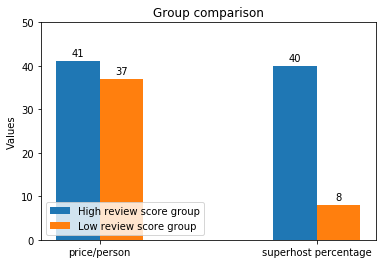

In [49]:
# plot numeric results first
labels = ['price/person', 'superhost percentage']
y_price    = [df3_high.price_per_person.mean(), df3_low.price_per_person.mean()]
y_superhost = [df3_high.host_is_superhost.mean()*100, df3_low.host_is_superhost.mean()*100]

high_value = [y_price[0], y_superhost[0]]
low_value  = [y_price[1], y_superhost[1]]

high_value_round = [round(h) for h in high_value]
low_value_round  = [round(r) for r in low_value]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, high_value_round, width, label='High review score group')
rects2 = ax.bar(x + width/2, low_value_round, width, label='Low review score group')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_title('Group comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = 3)
ax.set_ylim(0,50)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

#fig.tight_layout()

plt.savefig('Numeric_comparison.png', dpi = 100)

let's compare the home type, room type and cancellation policy difference between groups.

In [50]:
# function to make comparison plot
def plot_compare(labels, high_vect, low_vect, title):
    fig, ax = plt.subplots()
    
    x = np.arange(len(labels))
    width = 0.3
    
    high_bar = ax.bar(x - width/2, high_vect, width, label = 'High review score group')
    low_bar  = ax.bar(x + width/2, low_vect,  width, label = 'Low review score group')
    
    ax.set_ylabel('Counts')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc = 'best')
    
    autolabel(high_bar)
    autolabel(low_bar)
    
    save_name = title + '.png'
    plt.savefig(save_name, dpi = 100)

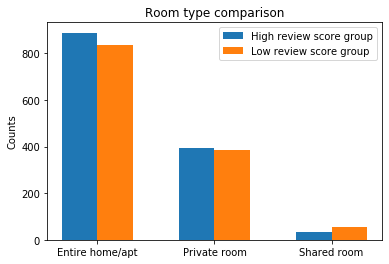

In [51]:
# plot room type comparison

# labels
labels_room    = ['Entire home/apt','Private room','Shared room']

# value vectors for room_type in two groups
high_vect_room = [df3_high[df3_high.room_type == col].shape[0] for col in labels_room]
low_vect_room  = [df3_low[df3_low.room_type   == col].shape[0] for col in labels_room]

# plot
plot_compare(labels_room, high_vect_room, low_vect_room, 'Room type comparison')

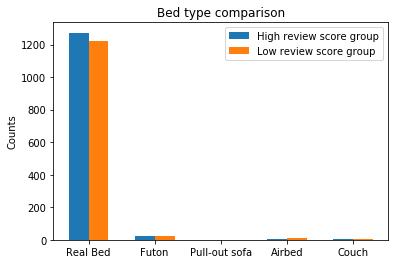

In [52]:
# plot bed type comparison

# labels of bed_type
labels_bed    = ['Real Bed','Futon','Pull-out sofa', 'Airbed', 'Couch']

# value vectors for bed_type in two groups
high_vect_bed = [df3_high[df3_high.bed_type == col].shape[0] for col in labels_bed]

low_vect_bed  = [df3_low[df3_low.bed_type ==col].shape[0] for col in labels_bed]

plot_compare(labels_bed, high_vect_bed, low_vect_bed, 'Bed type comparison')

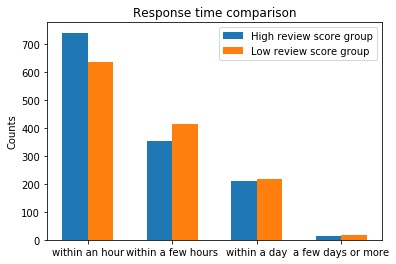

In [53]:
# labels for host_response_time
labels_response = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']

high_response = [df3_high[df3_high.host_response_time == col].shape[0] for col in labels_response]
low_response  = [df3_low[df3_low.host_response_time   == col].shape[0] for col in labels_response]

plot_compare(labels_response, high_response, low_response, 'Response time comparison')

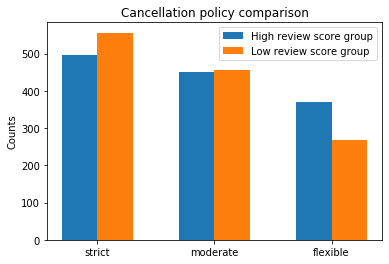

In [54]:
# cancellation policy
labels_cancel = ['strict', 'moderate', 'flexible']

high_cancel = [df3_high[df3_high.cancellation_policy == col].shape[0] for col in labels_cancel]
low_cancel  = [df3_low[df3_low.cancellation_policy   == col].shape[0] for col in labels_cancel]

plot_compare(labels_cancel, high_cancel, low_cancel, 'Cancellation policy comparison')